In [1]:
import IPython.display as display

# библиотека для аудиоанализа
import librosa
import librosa.display

import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# интерфейс для моделирования аудио для pytorch
import torchaudio

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import models, transforms

In [2]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
        
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses  

[документация torchaudio](https://pytorch.org/audio/)

[документация librosa](https://librosa.org/doc/latest/index.html)

In [3]:
display.Audio('input/ESC-50/audio/train/1-137-A-32.wav')

[Дока по IPython.display](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html)

В наборе [ESC-50](https://github.com/karolpiczak/ESC-50), который используется в этом примере, цифра в имени означает класс, к котормоу принадлежит звук. Получим список файлов и подсчитаем наличие каждого класса.

In [ ]:
import glob
from collections import Counter

esc50_list = [f.split('-')[-1].replace('.wav','') for f in glob.glob('input/ESC-50/audio/*.wav')]
Counter(esc50_list)

Если бы набор данных был бы несбаллансированным, можно было бы случайным образом накопировать объектов в классах, в которых не хватает данных. Это плохой вариант, но он работает.

## Создание набора данных из ESC-50

In [4]:
class ESC50(Dataset):
    def __init__(self, path):
        # Get directory listing from path
        files = Path(path).glob('*.wav')
        # Iterate through the listing and create a list of tuples (filename, label)
        self.items = [(str(f), f.name.split("-")[-1].replace(".wav","")) for f in files]
        self.length = len(self.items)
    def __getitem__(self, index):
        filename, label = self.items[index]
        audioTensor, rate = torchaudio.load(filename)
        return (audioTensor, int(label))     
    def __len__(self):
        return self.length

In [5]:
# пример
PATH_TO_ESC50 = 'input/ESC-50/audio/'

In [6]:
test_esc50 = ESC50(PATH_TO_ESC50 + "/train")
tensor, label = list(test_esc50)[0]

In [7]:
tensor

tensor([[0.0000, 0.0010, 0.0020,  ..., 0.0096, 0.0103, 0.0118]])

In [8]:
tensor.shape

torch.Size([1, 220500])

In [9]:
label

19

Набор ESC-50 разделен на 5 сбалансированных фолдов, обозначенных первой цифрой в названии файла. Мы можем 1,2 3 отправить на обучение, 4 на валидацию, а 5 на тест. Ну или каким-то другим способом сформировать трейн/вал/тест.

In [10]:
device = "cuda"
bs = 64

PATH_TO_ESC50 = Path.cwd() / 'input/ESC-50'

train_esc50 = ESC50(PATH_TO_ESC50 / "audio/train")
valid_esc50 = ESC50(PATH_TO_ESC50 / "audio/valid")
test_esc50  = ESC50(PATH_TO_ESC50 / "audio/test")

train_loader = torch.utils.data.DataLoader(train_esc50, batch_size = bs, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_esc50, batch_size = bs, shuffle = True)
test_loader  = torch.utils.data.DataLoader(test_esc50, batch_size = bs, shuffle = True)

## Сверточная сеть для данных ESC-50

Сеть будет построена на основе [этой статьи](https://arxiv.org/abs/1610.00087)

Для аудио используется 1D слои вместо 2D, т.к. аудисигнал имеет на одну размерность меньше, чем картинки.

In [11]:
class AudioNet(nn.Module):
    def __init__(self):
        super(AudioNet, self).__init__()
        self.conv1 = nn.Conv1d(100, 128, kernel_size=5, stride=4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(512, 50)

    def forward(self, x):
        x = x.unsqueeze(-1).view(-1, 100, 2205)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.squeeze(-1)
        x = self.fc1(x)
        return x

In [12]:
audionet = AudioNet()
audionet.to(device)

AudioNet(
  (conv1): Conv1d(100, 128, kernel_size=(5,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=50, 

Сохраним модель, сохраняем веса и используя функцию find_lr() находимо оптимальный лернинг рейт

In [13]:
torch.save(audionet.state_dict(), "output/audionet.pth")

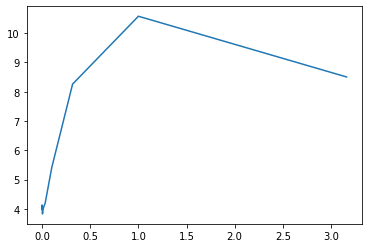

In [14]:
optimizer = optim.Adam(audionet.parameters(), lr=0.001)
logs, losses = find_lr(
    audionet, 
    nn.CrossEntropyLoss(), 
    optimizer, 
    train_loader, 
    device=device)

plt.plot(logs, losses)

In [15]:
# некогда разбираться почему такая лажа. Возьмем из примера в книжкеg и перезагружаем начальные веса
lr = 1e-5
audionet.load_state_dict(torch.load("output/audionet.pth"))
optimizer = optim.Adam(audionet.parameters(), lr=lr)

In [16]:
# обучаем в 20 эпох
train(audionet, 
      optimizer, 
      torch.nn.CrossEntropyLoss(),
      train_loader, 
      valid_loader, 
      epochs=20, 
      device=device)

/home/konstantin/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 4.05, Validation Loss: 3.92, accuracy = 0.02
Epoch: 1, Training Loss: 3.93, Validation Loss: 3.93, accuracy = 0.04
Epoch: 2, Training Loss: 3.84, Validation Loss: 3.93, accuracy = 0.04
Epoch: 3, Training Loss: 3.77, Validation Loss: 3.92, accuracy = 0.04
Epoch: 4, Training Loss: 3.72, Validation Loss: 3.90, accuracy = 0.04
Epoch: 5, Training Loss: 3.67, Validation Loss: 3.88, accuracy = 0.04
Epoch: 6, Training Loss: 3.62, Validation Loss: 3.86, accuracy = 0.04
Epoch: 7, Training Loss: 3.58, Validation Loss: 3.84, accuracy = 0.05
Epoch: 8, Training Loss: 3.54, Validation Loss: 3.83, accuracy = 0.04
Epoch: 9, Training Loss: 3.50, Validation Loss: 3.81, accuracy = 0.05
Epoch: 10, Training Loss: 3.47, Validation Loss: 3.80, accuracy = 0.06
Epoch: 11, Training Loss: 3.43, Validation Loss: 3.79, accuracy = 0.05
Epoch: 12, Training Loss: 3.40, Validation Loss: 3.78, accuracy = 0.04
Epoch: 13, Training Loss: 3.37, Validation Loss: 3.77, accuracy = 0.06
Epoch: 14, Train

Должно было быть 0.13-0.17%, но очевидно что-то пошло не так :)

В любом случае, работать с аудиволной бесперспективно. Лучше применить частотное преобразование (традиционно - преобразование Фурье). Таким образом можно работать с частотным спектром, который более информативен.

С помощью librosa можно создать спектрограмму в мел-шкале, которая определяет высоты звука, равноудаленные друг от друга, где 1000мел = 1000Гц

In [17]:
sample_data, sr = librosa.load('input/ESC-50/audio/train/1-137-A-32.wav', sr=None)
spectrogram = librosa.feature.melspectrogram(sample_data, sr=sr)

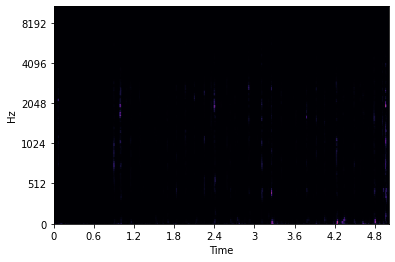

In [18]:
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel')

Если конвертировать спектрограмму в логарифмическую шкалу, тогда структура данных на спектрограмме будет понятнее. В данном случае np.max означает диапазон \[0, 1\]

In [19]:
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

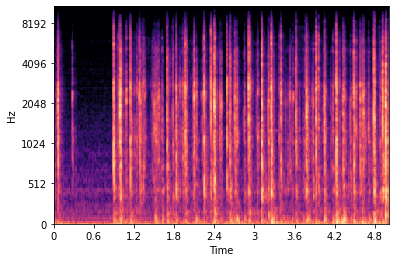

In [20]:
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')

Теперь мы можем покормить светочную сеть изображениями спектрпограмм!

## Спектрограммы, как данные для сверточных сетей

Чтобы не тормозить обучение пересчетом звуковог осигнала в спектрограммы, предварительно сформируем изображения и сохраним в тех-же каталогах, что и аудиофайлы. Другой подход - хранить все изображения в оперативке... но нужно много оперативной памяти.

Кроме того, в данном случае мы еще и управляем разрешением, через параметр dpi

In [ ]:
def precompute_spectrograms(path, dpi=50):
    files = Path(path).glob('*.wav')
    for filename in files:
        audio_tensor, sr = librosa.load(filename, sr=None)
        spectrogram = librosa.feature.melspectrogram(audio_tensor, sr=sr)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
        plt.gcf().savefig("{}{}_{}.png".format(filename.parent, dpi, filename.name), dpi=dpi)

precompute_spectrograms(PATH_TO_ESC50 + "/train")
precompute_spectrograms(PATH_TO_ESC50 + "/valid")

In [21]:
# создание датасета
class PrecomputedESC50(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}{}*.wav.png'.format(path.name, dpi))
        self.items = [(f,int(f.name.split("-")[-1].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')
        return (self.img_transforms(img), label)
            
    def __len__(self):
        return self.length

## Перенос обучения на ResNet50

In [22]:
spec_resnet = models.resnet50(pretrained=True)

for param in spec_resnet.parameters():
    param.requires_grad = False

spec_resnet.fc = nn.Sequential(nn.Linear(spec_resnet.fc.in_features,500),
                               nn.ReLU(),
                               nn.Dropout(),
                               nn.Linear(500, 50))

In [23]:
PATH_ESC50_TRAIN = PATH_TO_ESC50 / "audio/train"
PATH_ESC50_VALID = PATH_TO_ESC50 / "audio/valid"

In [24]:
PATH_ESC50_TRAIN

PosixPath('/home/konstantin/_code_/all-python-ml-learning/input/ESC-50/audio/train')

In [25]:
esc50pre_train = PrecomputedESC50(PATH_ESC50_TRAIN,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
)

esc50pre_valid = PrecomputedESC50(PATH_ESC50_VALID,
                                  img_transforms=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])
)

esc50_train_loader = torch.utils.data.DataLoader(esc50pre_train, batch_size = bs, shuffle=True)
esc50_val_loader = torch.utils.data.DataLoader(esc50pre_valid, batch_size = bs, shuffle=True)

Скорость обучения

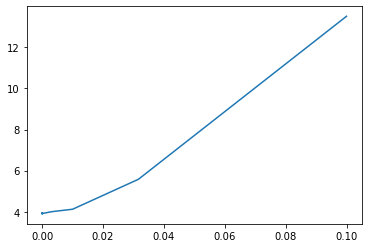

In [26]:
spec_resnet.to(device) 
torch.save(spec_resnet.state_dict(), "output/spec_resnet.pth")
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(spec_resnet.parameters(), lr=lr)
logs,losses = find_lr(spec_resnet, 
                      loss_fn, 
                      optimizer, 
                      esc50_train_loader, 
                      device=device)
plt.plot(logs, losses)

In [27]:
spec_resnet.load_state_dict(torch.load("output/spec_resnet.pth"))
optimizer = optim.Adam([
                        {'params': spec_resnet.conv1.parameters()},
                        {'params': spec_resnet.bn1.parameters()},
                        {'params': spec_resnet.relu.parameters()},
                        {'params': spec_resnet.maxpool.parameters()},
                        {'params': spec_resnet.layer1.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer2.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer3.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.layer4.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.avgpool.parameters(), 'lr': 1e-4},
                        {'params': spec_resnet.fc.parameters(), 'lr': 1e-8}
                        ], lr=1e-2)

train(spec_resnet, 
      optimizer, 
      nn.CrossEntropyLoss(), 
      esc50_train_loader, 
      esc50_val_loader, 
      epochs=5, 
      device=device)

for param in spec_resnet.parameters():
    param.requires_grad = True

train(spec_resnet, 
      optimizer, 
      nn.CrossEntropyLoss(), 
      esc50_train_loader, 
      esc50_val_loader, 
      epochs=5, 
      device=device)

/home/konstantin/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 3.93, Validation Loss: 3.92, accuracy = 0.02
Epoch: 1, Training Loss: 3.93, Validation Loss: 3.91, accuracy = 0.02
Epoch: 2, Training Loss: 3.92, Validation Loss: 3.91, accuracy = 0.02
Epoch: 3, Training Loss: 3.93, Validation Loss: 3.91, accuracy = 0.02
Epoch: 4, Training Loss: 3.93, Validation Loss: 3.91, accuracy = 0.02


RuntimeError: CUDA out of memory. Tried to allocate 36.00 MiB (GPU 0; 7.79 GiB total capacity; 6.34 GiB already allocated; 31.44 MiB free; 6.47 GiB reserved in total by PyTorch)

Слишком жирный последний линейный слой

[описание проблемы в факе pytorch](https://pytorch.org/docs/stable/notes/faq.html)

## Аугментация данных

два подхода - аугментировать саму волну либо аугментировать мел-спектрограммы

[все что умеет torchaudio - тут](https://pytorch.org/audio/transforms.html)

Лучше использовать SoX, т.к. он обладает большим набором функций, позволяющих добавлять к аудио, в том числе создавать цепочки эффектов

[torchaudio.sox_effects](https://pytorch.org/audio/sox_effects.html)

[документация SoX](http://sox.sourceforge.net/Main/HomePage)

In [28]:
# все доступные эффекты
torchaudio.sox_effects.effect_names()

['allpass',
 'band',
 'bandpass',
 'bandreject',
 'bass',
 'bend',
 'biquad',
 'chorus',
 'channels',
 'compand',
 'contrast',
 'dcshift',
 'deemph',
 'delay',
 'dither',
 'divide',
 'downsample',
 'earwax',
 'echo',
 'echos',
 'equalizer',
 'fade',
 'fir',
 'firfit',
 'flanger',
 'gain',
 'highpass',
 'hilbert',
 'input',
 'loudness',
 'lowpass',
 'mcompand',
 'noiseprof',
 'noisered',
 'norm',
 'oops',
 'output',
 'overdrive',
 'pad',
 'phaser',
 'pitch',
 'rate',
 'remix',
 'repeat',
 'reverb',
 'reverse',
 'riaa',
 'silence',
 'sinc',
 'speed',
 'splice',
 'stat',
 'stats',
 'stretch',
 'swap',
 'synth',
 'tempo',
 'treble',
 'tremolo',
 'trim',
 'upsample',
 'vad',
 'vol']

In [30]:
# пример класса для аугментации аудио
class ESC50WithPitchChange(Dataset):

    def __init__(self,path):
        # Get directory listing from path
        files = Path(path).glob('*.wav')
        # Iterate through the listing and create a list of tuples (filename, label)
        self.items = [(f,f.name.split("-")[-1].replace(".wav","")) for f in files]
        self.length = len(self.items)
        self.E = torchaudio.sox_effects.SoxEffectsChain()
        self.E.append_effect_to_chain("pitch", [0.5])
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        self.E.set_input_file(filename)
        audio_tensor, sample_rate = self.E.sox_build_flow_effects()
        return audio_tensor, label
        
    def __len__(self):
        return self.length

Аугментация спектрограмм осуществляется так-же, как и для любых других изображений. Единственное, не стоит обрезать изображения, т.к. это может привести к потере частот.

Подход заключается в попытке создать такие преобразования, которые были бы основаны на анализе структуры изображения. В нашем случае спектрограммы имеют одинаковую структуру, т.к. это частотный график. К таким методам относится частотное маскирование  и временное маскирование.

[Подробнее методы изложены в этой статье](https://arxiv.org/abs/1904.08779)

#### Частотное маскирвоание

заключается в случайном удалении частоты или набора частот из аудио.

Предполагается, что тензор будет иметь канал Х высота Х ширина, высоту надо задать в небольшом диапазоне, равной нулю или среднему изображения (в лог.спектрограммах оно равно 0). max_width определяет диапазон

In [31]:
class FrequencyMask(object):
    """
      Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     FrequencyMask(max_width=10, use_mean=False),
        >>> ])

    """

    def __init__(self, max_width, use_mean=True):
        self.max_width = max_width
        self.use_mean = use_mean

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of 
            size (C, H, W) where the frequency 
            mask is to be applied.

        Returns:
            Tensor: Transformed image with Frequency Mask.
        """
        start = random.randrange(0, tensor.shape[2])
        end = start + random.randrange(1, self.max_width)
        if self.use_mean:
            tensor[:, start:end, :] = tensor.mean()
        else:
            tensor[:, start:end, :] = 0
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + "(max_width="
        format_string += str(self.max_width) + ")"
        format_string += 'use_mean=' + (str(self.use_mean) + ')')

        return format_string

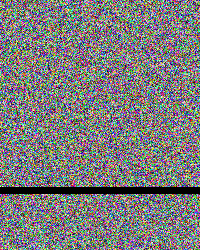

In [32]:
# пример маски на случайном тензоре
transforms.Compose([FrequencyMask(max_width=10, use_mean=False),
transforms.ToPILImage()])(torch.rand(3, 250, 200))

#### Временное маскирование

Делает тоже самое, но по временной шкале

In [33]:
class TimeMask(object):
    """
      Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     TimeMask(max_width=10, use_mean=False),
        >>> ])

    """

    def __init__(self, max_width, use_mean=True):
        self.max_width = max_width
        self.use_mean = use_mean

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of 
            size (C, H, W) where the time mask 
            is to be applied.

        Returns:
            Tensor: Transformed image with Time Mask.
        """
        start = random.randrange(0, tensor.shape[1])
        end = start + random.randrange(0, self.max_width)
        if self.use_mean:
            tensor[:, :, start:end] = tensor.mean()
        else:
            tensor[:, :, start:end] = 0
        return tensor

    def __repr__(self):
        format_string = self.__class__.__name__ + "(max_width="
        format_string += str(self.max_width) + ")"
        format_string += 'use_mean=' + (str(self.use_mean) + ')')
        return format_string

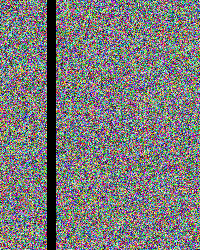

In [35]:
transforms.Compose([TimeMask(max_width=10, use_mean=False),
transforms.ToPILImage()])(torch.rand(3, 250, 200))

In [36]:
# итоговая обертка для примененеия обоих методов к набору
class PrecomputedTransformESC50(Dataset):
    def __init__(self, path, max_freqmask_width, max_timemask_width, use_mean=True, dpi=50):
        files = Path(path).glob('{}*.wav.png'.format(dpi))
        self.items = [(f,f.name.split("-")[-1].replace(".wav.png","")) for f in files]
        self.length = len(self.items)
        self.max_freqmask_width = max_freqmask_width
        self.max_timemask_width = max_timemask_width
        self.use_mean = use_mean
        self.img_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomApply([FrequencyMask(self.max_freqmask_width, self.use_mean)], p=0.5),
            transforms.RandomApply([TimeMask(self.max_timemask_width, self.use_mean)], p=0.5)
])
        
    def __getitem__(self, index):
        filename, label = self.items[index]
        img = Image.open(filename)
        return (self.img_transforms(img), label)
        
    def __len__(self):
        return self.length

[<span class="mark">Пример работы с torchaudio</span>](https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html)